In [12]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
import skimage.transform
import tensorflow as tf
import tensorflow_addons as tfa
import skimage.color
import numpy as np
import os

print(tf.__version__)

2.7.0


# Import the dataset
We used a homemade dataset composed of multiple fonts and line weights.
We only keep 250 randomly chosen instances of each character.

In [2]:
dataset_folder="homemade-digits"
images = np.ndarray((0, 28, 28))
labels = np.ndarray((0), dtype=int)

for i in np.arange(0, 10):
    file_names = os.listdir(f'../img/{dataset_folder}/{i}')
    np.random.shuffle(file_names)

    for file in file_names[:800]:
        cell = skimage.transform.resize(plt.imread(f'../img/{dataset_folder}/{i}/{file}'), (28, 28))
        cell = skimage.color.rgb2gray(cell)
        cell = np.where(cell < .25, 0, 1)
        images = np.concatenate((images, [cell]))
        labels = np.append(labels, i)

print(f'Train and test are composed of {len(images)} instances of {dataset_folder} dataset.')
print(images.shape)

Train and test are composed of 8000 instances of homemade-digits dataset.
(8000, 28, 28)


## Dataset overview

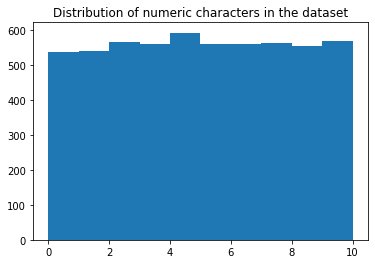

In [13]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size=0.7, random_state=42)

plt.hist(train_labels, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.title("Distribution of numeric characters in the dataset")
plt.show()

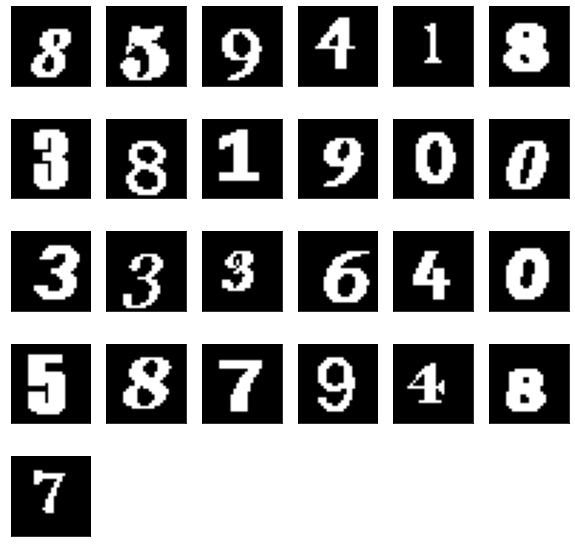

In [14]:
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    ax.xaxis.label.set_color("white")
    plt.imshow(train_images[i], cmap=plt.cm.gray)
    plt.xlabel(train_labels[i])

# Create and train the model

In [15]:
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.25),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',tfa.metrics.CohenKappa(num_classes=10, sparse_labels=True)])


model.fit(train_images, train_labels, epochs=7)
model.save('../model.h5', save_format='tf')

Epoch 1/7
175/175 [==============================] - 7s 34ms/step - loss: 0.8936 - accuracy: 0.7202 - cohen_kappa: 0.6890
Epoch 2/7
175/175 [==============================] - 6s 34ms/step - loss: 0.1258 - accuracy: 0.9659 - cohen_kappa: 0.9621
Epoch 3/7
175/175 [==============================] - 6s 33ms/step - loss: 0.0533 - accuracy: 0.9850 - cohen_kappa: 0.9833
Epoch 4/7
175/175 [==============================] - 5s 29ms/step - loss: 0.0367 - accuracy: 0.9895 - cohen_kappa: 0.9883
Epoch 5/7
175/175 [==============================] - 5s 30ms/step - loss: 0.0131 - accuracy: 0.9975 - cohen_kappa: 0.9972
Epoch 6/7
175/175 [==============================] - 5s 30ms/step - loss: 0.0084 - accuracy: 0.9980 - cohen_kappa: 0.9978
Epoch 7/7
175/175 [==============================] - 5s 28ms/step - loss: 0.0084 - accuracy: 0.9984 - cohen_kappa: 0.9982


In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                      

In [17]:
test_loss, test_acc, test_kappa = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)
print('Test kappa:', test_kappa)

75/75 [==============================] - 1s 6ms/step - loss: 0.0446 - accuracy: 0.9879 - cohen_kappa: 0.9866
Test accuracy: 0.9879166483879089
Test kappa: 0.9865689873695374


# Test the model on real sudoku cells

C:\Users\km169\AppData\Local\Temp/ipykernel_20264/1312716103.py:12: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  cell = skimage.color.rgb2gray(cell)


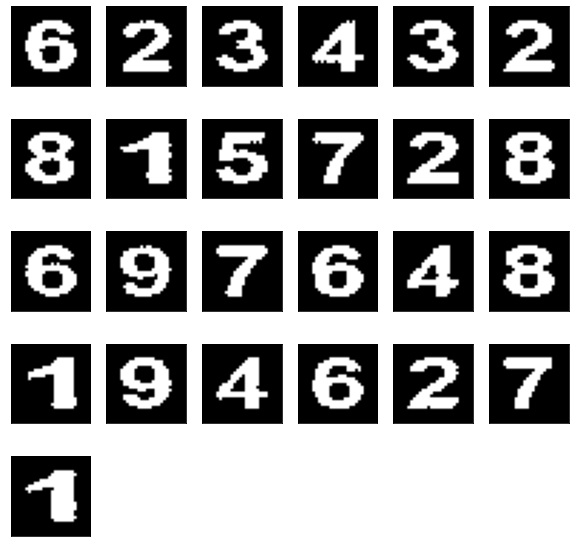

In [18]:
plt.figure(figsize=(10, 10))

for i in range(25):
    ax = plt.subplot(5, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    ax.xaxis.label.set_color("white")

    cell = plt.imread("../img/cells/"+str(i)+".png")
    cell = skimage.transform.resize(cell, (28, 28))
    cell = skimage.color.rgb2gray(cell)
    cell = np.where(cell < .5, 0, 1)
    cell = (np.expand_dims(cell,0))

    plt.imshow(cell[0], cmap=plt.cm.gray)
    plt.xlabel(np.argmax(model.predict(cell)))
plt.show()